Based on the following links to create this notebook:

https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy#scrollTo=bhsj7BTPHepg

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy


To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

In [ ]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (518 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 784 kB of 

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
!pip install gym[box2d]

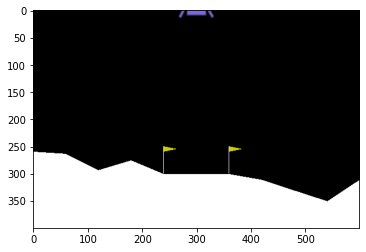

In [ ]:
# Box2d Environment
env = gym.make('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render('rgb_array'))


In [ ]:
state_size = env.observation_space
print("state size is:", state_size)
a = env.action_space
print("action size=",a) 
state = env.reset()
print(state)   

state size is: Box(-inf, inf, (8,), float32)
action size= Box(-1.0, 1.0, (2,), float32)
[-1.2948990e-03  1.4134583e+00 -1.3117316e-01  1.1280904e-01
  1.5072355e-03  2.9712701e-02  0.0000000e+00  0.0000000e+00]


# Action Space
            #is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)

In [ ]:
env = wrap_env(env)
done = False
iter = 0
print(done)
state = env.reset()

action = 1
TotalReward = 0;
while not done:
  iter +=1
  action = env.action_space.sample()
  print("action is:",action)
  observation, reward, done, _ = env.step(action)
  #print("state is:", observation)

  #if you want to see results on real-time 'open' the following 4 lines
  #screen = env.render(mode='rgb_array')
  #plt.imshow(screen)
  #ipythondisplay.clear_output(wait=True)
  #ipythondisplay.display(plt.gcf())
print(TotalReward)

False
action is: [-0.4202333  -0.22639294]
action is: [-0.00063439  0.5518342 ]
action is: [-0.858539   -0.50489265]
action is: [-0.082198    0.29732332]
action is: [-0.81088823 -0.46591908]
action is: [ 0.10779279 -0.6466116 ]
action is: [-0.7731798  -0.16821654]
action is: [-0.22804464 -0.14064218]
action is: [0.83532315 0.42842546]
action is: [ 0.46228662 -0.85384876]
action is: [0.6407495  0.71939933]
action is: [0.43636996 0.8365103 ]
action is: [ 0.34062448 -0.10481322]
action is: [-0.43644974  0.99962807]
action is: [-0.7814079  -0.72431844]
action is: [0.8701778 0.8024733]
action is: [-0.25975356 -0.66718394]
action is: [0.7380924  0.22220293]
action is: [ 0.69581753 -0.5515273 ]
action is: [-0.01787571  0.1670032 ]
action is: [-0.75753546  0.756812  ]
action is: [-0.13963337 -0.9551681 ]
action is: [-0.12365171  0.74015766]
action is: [0.5956968  0.03466279]
action is: [-0.78696346  0.1669943 ]
action is: [0.16723573 0.6340481 ]
action is: [-0.37209782  0.9065481 ]
action is: 

In [ ]:
env.close()
show_video()

In [ ]:
print(iter)

92


In [ ]:
#Draw random samples from a normal (Gaussian) distribution.
mu, sigma = 0, 0.05 # mean and standard deviation
s = np.random.normal(mu, sigma, 1)
print(s)

[-0.02039941]
